In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Extreme Clicking Paper Reproduce (Focus on generating Pseudo mask)

In [2]:
# read Json and make COCO API
import json
import pycocotools.coco as cocoapi
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
from matplotlib import pyplot as pyplot

VOC_extreme_json = '/data02/hyeonjun1882/VOC_dataset/annotations/voc_2012_extreme_train.json'

# with open(coco_extreme_json, "r") as f:
#     extreme_data = json.load(f)

voc = cocoapi.COCO(VOC_extreme_json)

loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


**Util Function**


In [76]:
def shortest_path(start, end, edge_response):
    """
    Finds the shortest path between two points in a given 2D image
    with edge response as the edge weight.

    Parameters:
    start (tuple): The start point coordinates (row, col).
    end (tuple): The end point coordinates (row, col).
    edge_response (np.ndarray): The edge response map of the same size as the original image.

    Returns:
    np.ndarray: A binary mask indicating the pixels in the shortest path.
    """
    rows, cols = edge_response.shape
    heap = [(0, start)]
    visited = np.zeros(edge_response.shape, dtype=np.bool)
    parent = {}

    while heap:
        (cost, curr) = heap.pop(0)
        if curr == end:
            break

        if visited[curr]:
            continue

        visited[curr] = True

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            x, y = curr[0] + dx, curr[1] + dy
            if x < 0 or x >= rows or y < 0 or y >= cols:
                continue
            new_cost = cost + edge_response[x, y]
            new_point = (x, y)
            if new_point not in parent or new_cost < parent[new_point][0]:
                parent[new_point] = (new_cost, curr)
                heap.append((new_cost, new_point))
                heap = sorted(heap, key=lambda x: x[0])

    path = []
    curr = end

    #import pdb;pdb.set_trace()
    while curr != start:
        path.append(list(curr))
        curr = parent[curr][1]
        
    path = path[::-1]

    return path

def find_surface_mask(img, annot, edge_prob):
    # Apply edge detector to obtain boundary probability
    # Find 4 paths connecting consecutive extreme points
    paths = []
    extreme_points = annot['extreme_points']
    for i in range(4):
        start, end = extreme_points[i], extreme_points[(i+1)%4]
        path = shortest_path(tuple(start), tuple(end), np.transpose(edge_prob))
        paths.extend(path)

    boundary_points = np.array(paths, dtype=np.int32)
    boundary_points = boundary_points.reshape(-1,1,2)
    binary_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(binary_mask, [boundary_points], 255)
    return binary_mask, paths

def EP_error_check(extreme_points, img_shape): #extreme point가 img_shape의 가장자리에 있을 경우 대비? 
    if extreme_points[3][0] == img_shape[1]:
        extreme_points[3][0] = extreme_points[3][0]-1
    if extreme_points[2][1] == img_shape[0]:
        extreme_points[2][1] = extreme_points[2][1]-1
    if extreme_points[1][0] == 0:
        extreme_points[1][0] == 1
    if extreme_points[0][1] ==0 :
        extreme_points[1][0] == 1
    return extreme_points

def find_surface_mask_via_crop(img, annot, whole_edge_prob_map):
    """
    Parameters:
    img: original image.
    annot: which contians 4 extreme points([t,t],[l,l],[b,b],[r,r]) / bbox (x,y,width,height)
    whole_edge_response (np.ndarray): The edge response map of the same size as the original image.

    1. crop the edge prob map using bounding box coordinate.
    2. find shortes path whose minimum edge response is hegihest within the cropped region

    Returns:
    np.ndarray: A binary mask indicating the pixels in the shortest path.
    """

    paths = []
    #bx, by, bwidth, bheight = list(map(int,annot['bbox']))    
    tt,ll,bb,rr = EP_error_check(annot['extreme_points'], img.shape)
    bheight = bb[1]-tt[1]
    bwidth = rr[0]-ll[0]
    bx = ll[0]
    by = tt[1]
    max_y, max_x = whole_edge_prob_map.shape

    from_x = max(0,bx-1)
    from_y = max(0,by-1)
    to_x = min(max_x,bx+bwidth+3)
    to_y = min(max_y,by+bheight+3)

    cropped_edge_prob_map = whole_edge_prob_map[from_y:to_y, from_x:to_x] #could make an error when bbox is tighted to the bottom
    print("edge map shape", cropped_edge_prob_map.shape)
    print("bwidth, bheigth", bwidth, bheight)

    for i in range(4):
        extreme_points = EP_error_check(annot['extreme_points'], img.shape)
        start, end = extreme_points[i], extreme_points[(i+1)%4]
        relocated_start = np.subtract(start,[from_x,from_y])
        reloacted_end = np.subtract(end,[from_x,from_y])
        path = shortest_path(tuple(relocated_start), tuple(reloacted_end), np.transpose(cropped_edge_prob_map))
        paths.extend(path)

    paths = list(map(lambda x: np.add(x, [from_x,from_y]), paths))

    boundary_points = np.array(paths, dtype=np.int32)
    boundary_points = boundary_points.reshape(-1,1,2)
    binary_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(binary_mask, [boundary_points], color=(255))
    return binary_mask, paths

# To make skeleton
def get_skeleton(binary_mask):
    # Get the morphological skeleton using cv2.morphologyEx
    skeleton = np.zeros(binary_mask.shape, dtype=np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_OPEN, (3, 3))
    done = False
    while not done:
        eroded = cv2.erode(binary_mask, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(binary_mask, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        binary_mask = eroded.copy()

        zeros = np.count_nonzero(binary_mask)
        if zeros == 0:
            done = True

    return skeleton
# To make Background model
def get_bbox_format_from_extreme_point(EP):
    tt,ll,bb,rr = EP
    return ll[0], tt[1], rr[0]-ll[0]+1, bb[1]-tt[1]+1

def get_double_size_bounding_box(bbox):
    x, y, width, height = bbox
    new_width = width * np.sqrt(2)
    new_height = height * np.sqrt(2) #이거  처리해줘야함. 
    new_x = x - (new_width - width) / 2
    new_y = y - (new_height - height) / 2
    return [int(new_x), int(new_y), int(new_width), int(new_height)]

def draw_ring(larger_box, original_box, img_shape):
    x, y, width, height = original_box
    new_x, new_y, new_width, new_height =larger_box
    x_end = min(img_shape[1], new_x + new_width)
    y_end = min(img_shape[0], new_y + new_height)
    x_start = max(0, new_x)
    y_start = max(0, new_y)
    
    binary_mask = np.zeros(img_shape,dtype = np.uint8)
    binary_mask[y_start:y_end, x_start:x_end] = 255
    binary_mask[y:y+height, x:x+width]=0
    
    return binary_mask


**SHOW coco IMAGE FROM ITS URL**

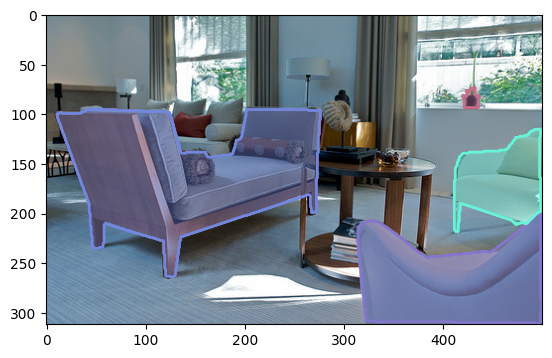

In [77]:

voc_dir_path = '/data02/hyeonjun1882/VOC_dataset/train/'

imgIds = voc.getImgIds(imgIds =[8981]) # load img Ids whose number is 13 full image (test하기좋음))
Img = voc.loadImgs(imgIds)[0] #load images whose number is 174231
annIds = voc.getAnnIds(imgIds=Img['id'], iscrowd=None)
anns = voc.loadAnns(annIds) #annotation can gets from here. 
voc_img_path = voc_dir_path +Img['file_name']
img = cv2.imread(voc_img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
voc.showAnns(anns)
#anns[0]['extreme_points'



**Draw Extreme Points on the image**

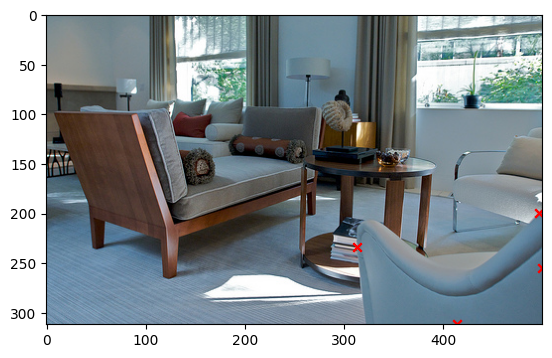

In [78]:
#Plot Every Extreme Points on Image

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for i in range(2):
    annot = anns[0]
    eps = np.array(annot['extreme_points'])
    plt.scatter(eps[:,0], eps[:,1], color="red", marker="x")

plt.show()


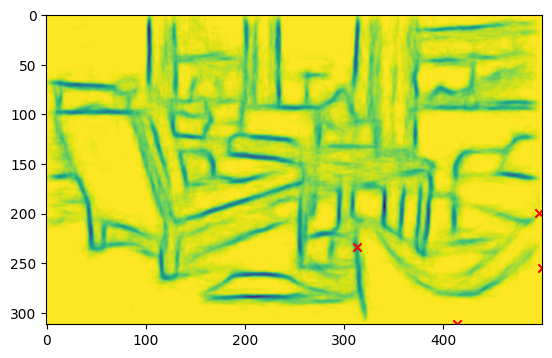

In [79]:
detector = cv2.ximgproc.createStructuredEdgeDetection('model.yml.gz')
rgb_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im = detector.detectEdges(np.float32(rgb_im)/255.0)
orimap = detector.computeOrientation(im)
edges= detector.edgesNms(im, orimap) #edges -> edge probability map 


plt.imshow(1-im)

annot = anns[0]
eps = np.array(annot['extreme_points'])
plt.scatter(eps[:,0], eps[:,1], color="red", marker="x")

plt.show()


**Initial object surfaces estimate from Extreme Clicks**


edge map shape (114, 188)
bwidth, bheigth 186 112


/tmp/ipykernel_1343175/3328618976.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  visited = np.zeros(edge_response.shape, dtype=np.bool)


Text(0.5, 1.0, 'Background')

(-0.5, 499.5, 311.5, -0.5)

Text(0.5, 1.0, 'Foreground')

(-0.5, 499.5, 311.5, -0.5)

Text(0.5, 1.0, 'Skeleton')

(-0.5, 499.5, 311.5, -0.5)

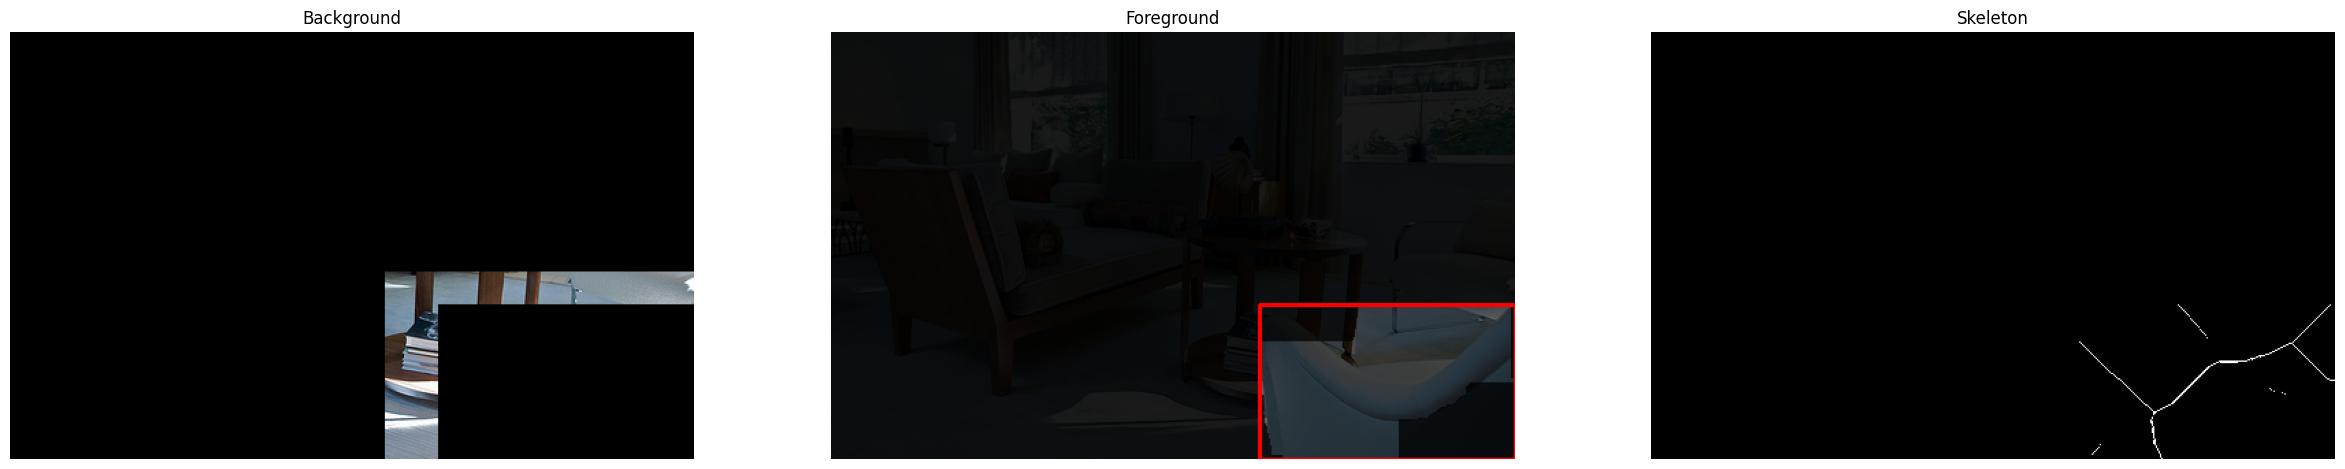

In [42]:
annot = anns[0]
#GET INITIAL SURFACE
initial_surface, path_pixels = find_surface_mask_via_crop(img, annot, 1-im) #mask has initial binary mask 
_, binary_mask = cv2.threshold(initial_surface, 128, 255, cv2.THRESH_BINARY)
cropped_img = cv2.bitwise_and(img, img, mask=binary_mask)
overlapped_img = cv2.addWeighted(img, 0.1, cropped_img, 0.3, 0)
bx, by, bwidth, bheight = list(map(int,annot['bbox']))
overlapped_img_with_bbox = cv2.rectangle(overlapped_img, (bx, by), (bx+bwidth, by+bheight), (0,0,255),2)

#GET SKELETON
skeleton = get_skeleton(initial_surface)
#GET BACKGROUND
bbox = get_bbox_format_from_extreme_point(annot['extreme_points'])
larger_box = get_double_size_bounding_box(bbox)
background = draw_ring(larger_box, bbox, img.shape[:2])
masked = cv2.bitwise_or(img, img, mask=background)

# Overlap the cropped image onto the original image


fig = plt.figure(figsize=(30,90))
rows = 1
cols = 3

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
ax1.set_title('Background')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(overlapped_img_with_bbox, cv2.COLOR_BGR2RGB))
ax2.set_title('Foreground')
ax2.axis("off")

ax2 = fig.add_subplot(rows, cols, 3)
ax2.imshow(cv2.cvtColor(skeleton, cv2.COLOR_BGR2RGB))
ax2.set_title('Skeleton')
ax2.axis("off")
 
plt.show()

**GRABCUT initialized by mask**

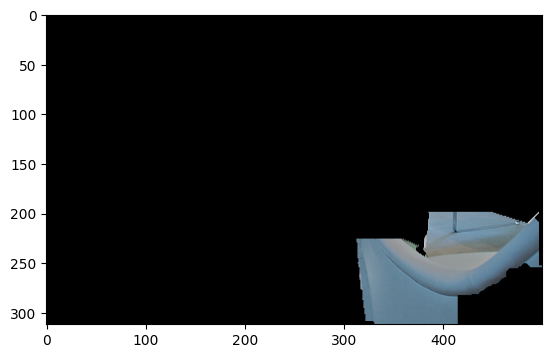

In [43]:
mask = np.zeros(img.shape[:2],np.uint8)
mask[initial_surface== 255] = cv2.GC_PR_FGD
mask[skeleton == 255] = cv2.GC_FGD
mask[background ==255] = cv2.GC_BGD

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_MASK)

psuedo_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
segment_img = img*psuedo_mask[:,:,np.newaxis]

plt.imshow(cv2.cvtColor(segment_img, cv2.COLOR_BGR2RGB))

**GRABCUT initialized by rect**

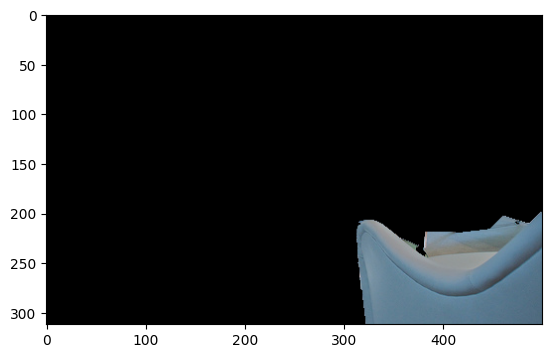

In [44]:
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = tuple(map(int,annot['bbox']))

mask, bgdModel, fgdModel = cv2.grabCut(img,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
segment_img_grabcut_from_bbox = img*mask2[:,:,np.newaxis]
plt.imshow(cv2.cvtColor(segment_img_grabcut_from_bbox, cv2.COLOR_BGR2RGB))

[{'segmentation': [[330.5,
    311.0,
    330.5,
    310.0,
    330.0,
    309.5,
    329.5,
    309.0,
    329.0,
    308.5,
    328.0,
    308.5,
    327.0,
    308.5,
    326.0,
    308.5,
    325.0,
    308.5,
    324.0,
    308.5,
    323.0,
    308.5,
    322.0,
    308.5,
    321.5,
    308.0,
    321.5,
    307.0,
    321.5,
    306.0,
    321.5,
    305.0,
    321.5,
    304.0,
    321.5,
    303.0,
    321.5,
    302.0,
    321.0,
    301.5,
    320.5,
    301.0,
    320.5,
    300.0,
    320.5,
    299.0,
    320.5,
    298.0,
    320.5,
    297.0,
    320.5,
    296.0,
    320.0,
    295.5,
    319.5,
    295.0,
    319.5,
    294.0,
    319.5,
    293.0,
    319.5,
    292.0,
    319.5,
    291.0,
    319.5,
    290.0,
    319.5,
    289.0,
    319.5,
    288.0,
    319.0,
    287.5,
    318.5,
    287.0,
    318.5,
    286.0,
    318.5,
    285.0,
    318.5,
    284.0,
    318.5,
    283.0,
    318.5,
    282.0,
    318.5,
    281.0,
    318.5,
    280.0,
    318.5,
    2

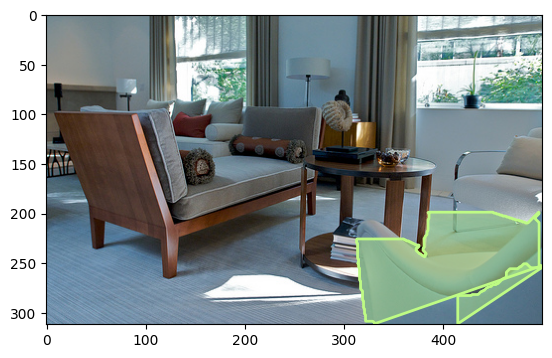

In [46]:
import json
import numpy as np
from pycocotools import mask as cocomask
from skimage import measure

    
def make_coco_annot_from_binary_mask(psuedo_mask, real_annotation):
    fortran_ground_truth_binary_mask = np.asfortranarray(psuedo_mask)
    encoded_ground_truth = cocomask.encode(fortran_ground_truth_binary_mask)
    ground_truth_area = cocomask.area(encoded_ground_truth)
    ground_truth_bounding_box = cocomask.toBbox(encoded_ground_truth)
    contours = measure.find_contours(psuedo_mask, 0.5)
    
    annotation = {
        "segmentation": [],
        "area": ground_truth_area.tolist(),
        "iscrowd": real_annotation['iscrowd'],
        "image_id": real_annotation['image_id'],
        "bbox": real_annotation['bbox'],
        "category_id": real_annotation['category_id'],
        "id": real_annotation['id']
    }
    
    for contour in contours:
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        annotation["segmentation"].append(segmentation)
    
    return annotation
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
voc.showAnns([make_coco_annot_from_binary_mask(psuedo_mask, anns[0])])



In [22]:
len(anns)

4

In [3]:
#check VOC
import json

voc_json = '/data02/hyeonjun1882/VOC_dataset/annotations/voc_2012_train.json'
voc_extreme_json = '/data02/hyeonjun1882/VOC_dataset/annotations/voc_2012_extreme_train.json'
voc_pseudo_json = '/data02/hyeonjun1882/VOC_dataset/annotations/voc_2012_pseudo_mask_from_extreme_train.json'

with open(voc_json, "r") as f:
    data = json.load(f)

with open(voc_extreme_json, "r") as f:
    extreme_data = json.load(f)


with open(voc_pseudo_json, "r") as f:
    pseudo_data = json.load(f)



In [20]:
k = 0
for i in range(len(extreme_data['annotations'])):
    if len(extreme_data['annotations'][i]['segmentation']) > 1 :
        k = k +1
        print(i)
print(k)   


4
17
20
26
28
31
38
71
86
90
100
103
105
106
113
114
119
123
130
134
135
138
144
150
155
162
164
186
190
198
202
203
207
209
211
213
214
219
220
226
234
239
241
244
248
255
261
264
268
269
276
279
293
297
309
312
316
319
338
339
357
358
367
368
369
372
387
388
389
390
394
413
429
431
432
438
445
448
455
462
463
467
471
473
479
489
495
499
507
509
513
517
527
528
534
536
553
558
559
562
565
567
571
586
587
589
590
606
610
616
618
623
628
635
647
649
651
652
656
660
662
663
664
666
667
668
669
670
671
676
677
678
681
690
701
703
708
711
717
718
730
735
747
748
755
756
757
759
766
767
768
769
782
784
785
786
787
788
789
794
796
797
802
807
809
814
816
818
820
824
829
833
843
847
851
856
861
864
867
870
871
873
880
881
883
889
890
892
900
902
908
917
919
928
932
937
947
951
956
959
960
964
970
976
983
984
985
987
991
1010
1017
1026
1048
1054
1055
1057
1064
1067
1071
1074
1082
1087
1115
1120
1129
1133
1134
1140
1163
1165
1167
1172
1182
1186
1188
1201
1209
1211
1212
1215
1224
1229
1230
1232


In [46]:
len(pseudo_data['annotations'])
#extreme_data['annotations'][99]

25815

Exterme Point Psuedo Mask

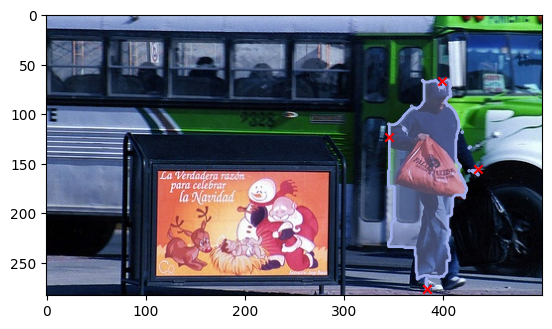

In [18]:
i = 25813
anns = pseudo_data['annotations'][i]
exs_anns = extreme_data['annotations'][i]
voc_dir_path = '/data02/hyeonjun1882/VOC_dataset/train/'

img_id_from_annot = anns['image_id']
Img = voc.loadImgs(img_id_from_annot)[0]
voc_img_path = voc_dir_path +Img['file_name']
img = cv2.imread(voc_img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
voc.showAnns([anns])
eps = np.array(exs_anns['extreme_points'])
plt.scatter(eps[:,0], eps[:,1], color="red", marker="x")




GT_Pseudo_mask

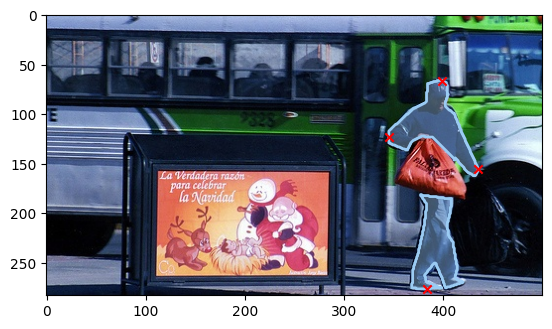

In [19]:
anns = extreme_data['annotations'][i]
exs_anns = extreme_data['annotations'][i]
voc_dir_path = '/data02/hyeonjun1882/VOC_dataset/train/'

img_id_from_annot = anns['image_id']
Img = voc.loadImgs(img_id_from_annot)[0]
voc_img_path = voc_dir_path +Img['file_name']
img = cv2.imread(voc_img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
voc.showAnns([anns])
plt.scatter(eps[:,0], eps[:,1], color="red", marker="x")
eps = np.array(exs_anns['extreme_points'])

In [11]:
extreme_data['annotations'][i]['segmentation']

[[116,
  0,
  113,
  3,
  110,
  3,
  108,
  5,
  108,
  6,
  105,
  9,
  105,
  10,
  102,
  13,
  102,
  14,
  97,
  19,
  97,
  20,
  96,
  21,
  96,
  22,
  95,
  23,
  95,
  35,
  96,
  36,
  96,
  43,
  95,
  44,
  95,
  58,
  94,
  59,
  93,
  59,
  93,
  60,
  92,
  61,
  79,
  61,
  78,
  62,
  74,
  62,
  73,
  63,
  68,
  63,
  67,
  64,
  65,
  64,
  64,
  65,
  62,
  65,
  61,
  66,
  59,
  66,
  58,
  67,
  57,
  67,
  56,
  68,
  54,
  68,
  53,
  69,
  51,
  69,
  50,
  70,
  49,
  70,
  48,
  71,
  46,
  71,
  43,
  74,
  43,
  75,
  41,
  77,
  41,
  78,
  39,
  80,
  38,
  80,
  36,
  82,
  35,
  82,
  33,
  84,
  32,
  84,
  31,
  85,
  31,
  86,
  30,
  87,
  30,
  89,
  29,
  90,
  29,
  92,
  28,
  93,
  28,
  96,
  26,
  98,
  26,
  99,
  23,
  102,
  23,
  103,
  21,
  105,
  21,
  106,
  20,
  107,
  20,
  108,
  19,
  109,
  19,
  110,
  18,
  111,
  18,
  112,
  17,
  113,
  17,
  114,
  16,
  115,
  16,
  116,
  15,
  117,
  15,
  118,
  14,
  119,
  14,
  

Exception: datasetType not supported

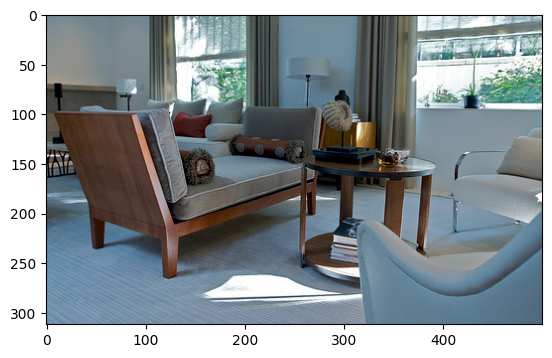

In [32]:

voc_dir_path = '/data02/hyeonjun1882/VOC_dataset/train/'

imgIds = voc.getImgIds(imgIds =[8981]) # load img Ids whose number is 13 full image (test하기좋음))
Img = voc.loadImgs(imgIds)[0] #load images whose number is 174231
annIds = voc.getAnnIds(imgIds=Img['id'], iscrowd=None)
anns = voc.loadAnns(annIds) #annotation can gets from here. 
voc_img_path = voc_dir_path +Img['file_name']
img = cv2.imread(voc_img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
voc.showAnns([anns])
#anns[0]['extreme_points'



[{'segmentation': [[187.0,
    42.5,
    186.5,
    42.0,
    186.5,
    41.0,
    186.5,
    40.0,
    186.5,
    39.0,
    186.5,
    38.0,
    187.0,
    37.5,
    187.5,
    38.0,
    187.5,
    39.0,
    187.5,
    40.0,
    187.5,
    41.0,
    187.5,
    42.0,
    187.0,
    42.5],
   [156.5,
    499.0,
    156.5,
    498.0,
    156.5,
    497.0,
    156.5,
    496.0,
    156.0,
    495.5,
    155.0,
    495.5,
    154.0,
    495.5,
    153.0,
    495.5,
    152.5,
    495.0,
    152.0,
    494.5,
    151.5,
    494.0,
    151.5,
    493.0,
    151.0,
    492.5,
    150.0,
    492.5,
    149.0,
    492.5,
    148.5,
    492.0,
    148.0,
    491.5,
    147.5,
    491.0,
    147.0,
    490.5,
    146.0,
    490.5,
    145.5,
    491.0,
    145.0,
    491.5,
    144.5,
    492.0,
    144.0,
    492.5,
    143.5,
    493.0,
    143.5,
    494.0,
    143.5,
    495.0,
    143.0,
    495.5,
    142.0,
    495.5,
    141.0,
    495.5,
    140.5,
    495.0,
    140.5,
    494.0,
    14

Function A executed.
A


Function A executed.
A
